# Import supporting package

In [1]:
import xarray as xr
import numpy as np

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

import matplotlib.pyplot as plt

from DataContainer.ReadData import read_hdf5_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FitAnalyser import NewFitModel
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

In [2]:
import numpy as np

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "arial"

In [3]:
def Ncount_to_atoms():
    return 1 / 8.4743e-14 / 0.3725 * 5.86e-6**2 / 0.6606**2

In [4]:
import csv

colormap = np.zeros((1024, 3))

with open('smooth-cool-warm-table-float-1024.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    i = 0
    for row in spamreader:
        try:
            a = row[0].split(',')
            colormap[i, 0] = float(a[1])
            colormap[i, 1] = float(a[2])
            colormap[i, 2] = float(a[3])
            i = i + 1
        except:
            pass

colormap = ListedColormap(colormap)

In [5]:
data_colors = colormap(np.linspace(0, 1, 7))
plot_blue = data_colors[-3]
plot_red = data_colors[-1]
plot_red_alpha = 1

## Start a client for parallel computing

In [6]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

<Client: 'tcp://127.0.0.1:63894' processes=6 threads=60, memory=55.88 GiB>

## Set global path for experiment

In [7]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_0",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_1",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_2",
}


In [8]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Repetition_scan" + "/"

# MOT optimize

## 09.06.2023

The detected scaning axes and values are: 

{'cmot_initial_current': array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28]), 'initial_freq': array([100.5, 100.9, 101.3, 101.7, 102.1, 102.5, 102.9, 103.3, 103.7,
       104.1]), 'runs': array([0., 1., 2.])}


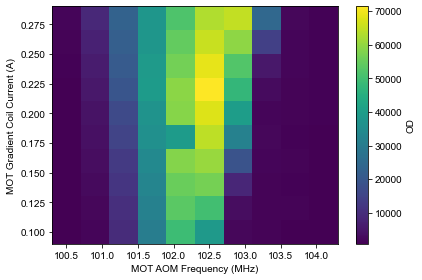

In [10]:
folderPath = img_dir + SequenceName + '2023/06/09'# get_date()

shotNum = "0010"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in range(len(groupList))
}

dataSet = dataSetDict["camera_0"]

print_scanAxis(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

imageAnalyser.center = (690, 1435)
imageAnalyser.span = (1000, 700)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

Ncount = imageAnalyser.get_Ncount(dataSet_cropOD)
Ncount_mean = calculate_mean(Ncount)
Ncount_std = calculate_std(Ncount)

fig = plt.figure()
# ax = fig.gca()
Ncount_mean.plot.pcolormesh()
plt.xlabel('MOT AOM Frequency (MHz)')
plt.ylabel('MOT Gradient Coil Current (A)')
plt.tight_layout()
# plt.grid(visible=1)
plt.show()

In [31]:
freq = -(Ncount_mean.initial_freq.to_numpy() - 99.969) *2 / 0.136
current = Ncount_mean.cmot_initial_current.to_numpy() * 5.17
data = Ncount_mean.to_numpy() * Ncount_to_atoms()

X, Y = np.meshgrid(freq, current)

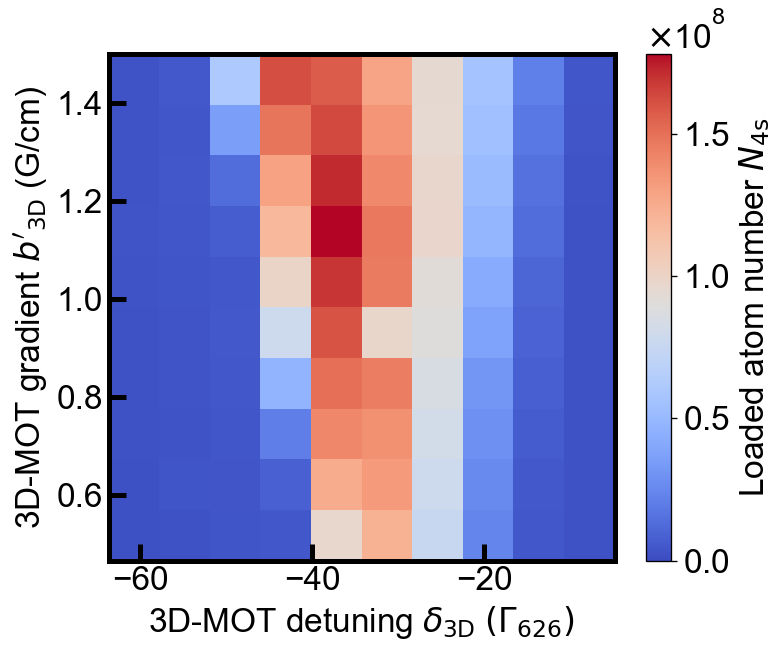

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(6.8, 6.8/4*3*2*(1 + 16/50)), dpi=120)
grid = fig.add_gridspec(4, 1, height_ratios=[2, 50, 10, 50], wspace=0.4, hspace=0.1)

filter = ''
edgecolor = None

colorbar_ticks = np.linspace(0, 2.5e8, 6)

plot_axes = plt.subplot(grid[1, 0])

im = plot_axes.pcolormesh(X, Y, data, cmap=colormap, edgecolor=edgecolor, vmin=0)

colorbar = fig.colorbar(im, ax=plot_axes, ticks=np.array([0, 0.5, 1, 1.5, 2])*1e8)
colorbar.formatter.set_powerlimits((0, 0))
colorbar.formatter.set_useMathText(True)
colorbar.ax.yaxis.set_offset_position('left')
colorbar.ax.tick_params(axis='both', labelsize=20)
colorbar.ax.yaxis.offsetText.set_fontsize(20)

plot_axes.set_xlabel("3D-MOT detuning $\delta_\mathrm{3D}$ $(\Gamma_\mathrm{626})$", fontsize=20)
plot_axes.set_ylabel("3D-MOT gradient $b'_\mathrm{3D}$ (G/cm)", fontsize=20)
colorbar.set_label("Loaded atom number $N_\mathrm{4s}$", fontsize=20)

plot_axes.tick_params(axis='both', which='major', labelsize=20)
plot_axes.tick_params(axis='both', which='minor', labelsize=16)
plot_axes.xaxis.offsetText.set_fontsize(20)
plot_axes.yaxis.offsetText.set_fontsize(20)

plt.setp(plot_axes.spines.values(), linewidth=3)
plot_axes.xaxis.set_tick_params(width=3)
plot_axes.yaxis.set_tick_params(width=3)
plot_axes.tick_params(direction='in', length=10)

# # plotting.figure[dataExtractor_key].colorbar_min = 0
# # plotting.figure[dataExtractor_key].colorbar_max = 2.5e8

# plotting.figure[dataExtractor_key].add_pcolormesh_plot(cmap=colormap, edgecolor=edgecolor, grid=plot_axes)
# plotting.figure[dataExtractor_key].add_axes_label()
# # plotting.figure[dataExtractor_key].add_color_bar(ticks=colorbar_ticks)
# plotting.figure[dataExtractor_key].add_color_bar(ticks=np.linspace(0, 8, 5))
# plotting.figure[dataExtractor_key].colorbar.ax.set_yticklabels(['{:.1f}'.format(x) for x in np.linspace(0, 8, 5)])

# plotting.figure[dataExtractor_key].colorbar.ax.text(3.3, 7.69, '$\\times 10^{7}$', va='bottom', weight='bold', fontsize=20)

# # plotting.figure[dataExtractor_key].set_color_bar_offset_position(0, 1.07)

# # plotting.figure[dataExtractor_key].plot_axes.set_xlim([-30, -55])
# # plotting.figure[dataExtractor_key].plot_axes.set_ylim([0.15, 0.65])

# # plt.xticks([-40])

# plotting.figure[dataExtractor_key].plot_axes.set_xlabel("3D-MOT detuning $\delta_\mathrm{3D} / \Gamma_{626}$", fontsize=20)
# plotting.figure[dataExtractor_key].plot_axes.set_ylabel("3D-MOT gradient $b'_\mathrm{3D}$ (G/cm)", fontsize=20)
# plotting.figure[dataExtractor_key].colorbar.set_label("Loaded atom number $N_\mathrm{4s}$", fontsize=20)

# plot_axes = plt.subplot(grid[0, 0])
# plot_axes.text(-0.17, 1.0, '(a)', va='bottom', weight='bold', fontsize=20)
# plot_axes.set_axis_off()

fig.savefig('figS3_v1.pdf', bbox_inches = "tight")

plt.show()